In [595]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [663]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn.linear_model as skl_lm
from sklearn import preprocessing
from sklearn import neighbors
from sklearn.feature_selection import RFE,RFECV
from sklearn.svm import SVR, SVC
import statsmodels.api as sm
import statsmodels.formula.api as smf

plt.style.use('seaborn-white')

from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, BaggingRegressor, RandomForestRegressor, GradientBoostingRegressor
import graphviz
from sklearn.model_selection import train_test_split,StratifiedKFold,cross_val_score,RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, precision_score, roc_curve, auc, mean_squared_error

In [664]:
import os
os.environ["PATH"] += os.pathsep + "/usr/local/Cellar"

In [665]:
#We will perform and improved version of logistic regression (with feature selection),
#and also single classification decision tree and random forest
#First, we read in and process the data

In [666]:
df = pd.read_csv('Examples/processed_cleveland.csv')

In [667]:
df.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,1,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,2,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,3,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,4,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,5,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [668]:
df.shape

(303, 15)

In [669]:
df=df.drop(['1'],axis=1)

In [670]:
#Rename the columns with the actual column names
df=df.rename(columns={'2':'age','3':'sex','4':'cp','5':'trestbps','6':'chol','7':'fbs','8':'restecg','9':'thalach','10':'exang','11':'oldpeak','12':'slope','13':'ca',\
                    '14':'thai','15':'num'})
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thai,num
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6,0
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3,2
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7,1
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3,0
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3,0


In [671]:
#Drop out entries with question mark (not availabe) values.
df=df.replace({'?':np.nan}).dropna()
df=df.dropna()
df['num'] = (df['num'] > 0).astype(int)

In [672]:
#Get X and y
y=df.num
X=df.drop(['num'],axis=1)
X.head()
y.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thai
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3


0    0
1    1
2    1
3    0
4    0
Name: num, dtype: int64

In [673]:
#Split up the data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=.5, random_state=3)

In [674]:
X_train.shape
X_test.shape


(148, 13)

(149, 13)

In [ ]:
#First we attempt to build a single classification decision tree.

In [675]:
#To find ideal tree depth, we use cross validation=10 folds
#ref: https://towardsdatascience.com/how-to-find-decision-tree-depth-via-cross-validation-2bf143f0f3d6
cv_scores=[]
cv=10
acc_scores=[]
for x in range(1,13):
    clf = tree.DecisionTreeClassifier(max_depth=x)
    #clf.fit(X_train, y_train)
    cv_score=cross_val_score(clf,X_train,y_train,cv=cv,scoring='accuracy')
    cv_scores.append(cv_score.mean())
    acc_scores.append(clf.fit(X_train,y_train).score(X_train,y_train))

print("Max mean cv score at depth: {0}".format(cv_scores.index(max(cv_scores))))
clf = tree.DecisionTreeClassifier(max_depth=cv_scores.index(max(cv_scores))+1)
clf.fit(X_train,y_train)

Max mean cv score at depth: 9


DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=10, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

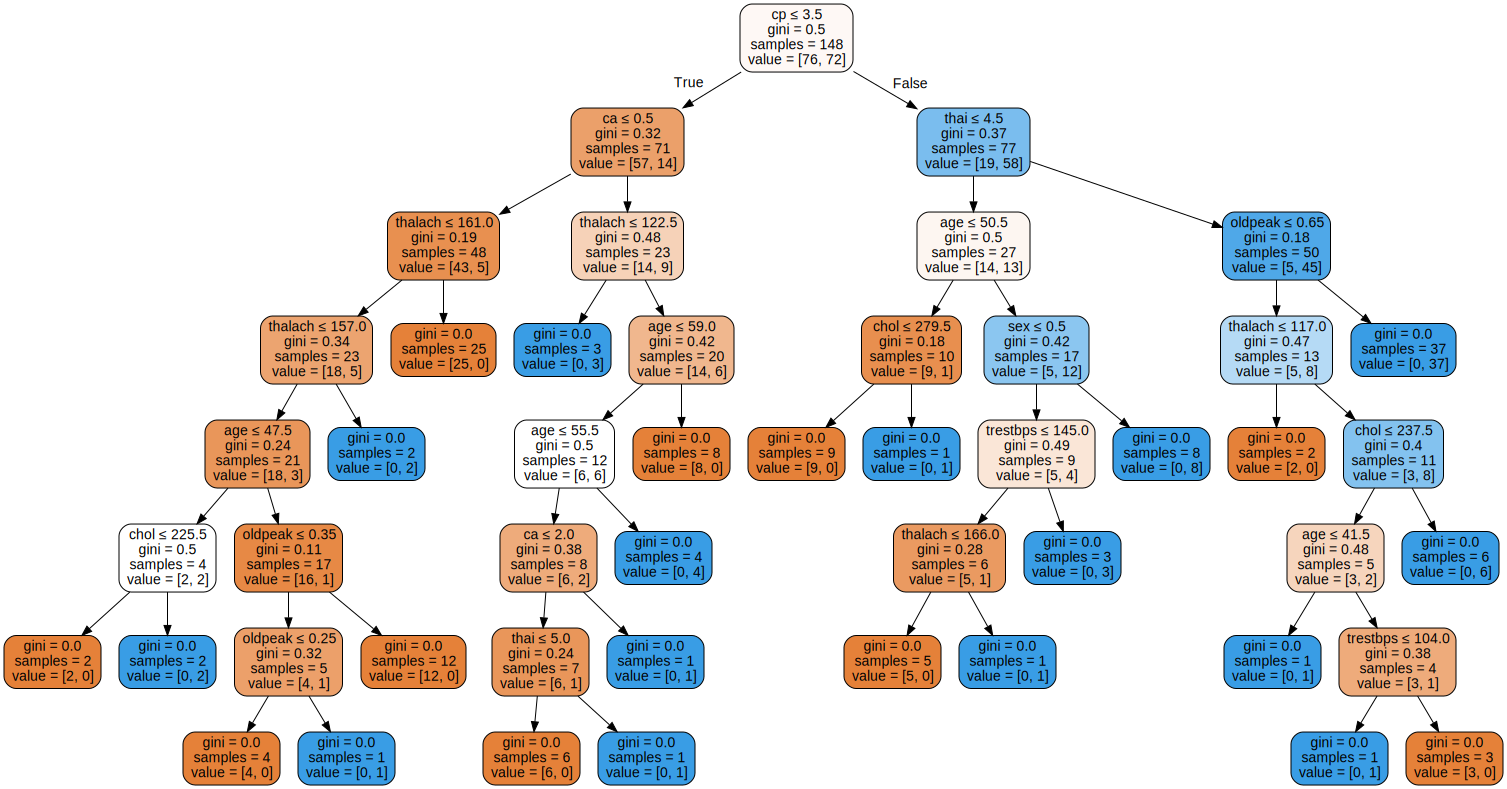

In [697]:
#From demonstration 33
dot_data = tree.export_graphviz(clf, out_file=None, 
                         feature_names=X.columns, 
                         filled=True, rounded=True,  
                         special_characters=True,
                         precision=2)
tree_viz = graphviz.Source(dot_data)
tree_viz


In [698]:
pred=clf.predict(X_test)
print(classification_report(y_test, pred))
clf.score(X_test,y_test)

              precision    recall  f1-score   support

           0       0.78      0.77      0.78        84
           1       0.71      0.72      0.72        65

    accuracy                           0.75       149
   macro avg       0.75      0.75      0.75       149
weighted avg       0.75      0.75      0.75       149



0.7516778523489933

In [699]:
#ref from demo 33
cm = pd.DataFrame(confusion_matrix(y_test, pred).T, index=['No disease', 'Yes Disease'], columns=['No Disease', 'Yes Disease'])
cm.index.name = 'Predicted'
cm.columns.name = 'True'
cm




True,No Disease,Yes Disease
Predicted,,
No disease,65,18
Yes Disease,19,47


In [682]:
#Then, we try RandomForest approach.

In [683]:

regr = RandomForestRegressor(max_features=7, random_state=1)
regr.fit(X_train, y_train)


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

"\nrf = RandomForestRegressor()\n# Random search of parameters, using 3 fold cross validation, \n# search across 100 different combinations, and use all available cores\nrandom_grid={'max_features':['auto','sqrt']}\nregr = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)\n# Fit the random search model\nregr.fit(X_train, y_train)\n"

149

149

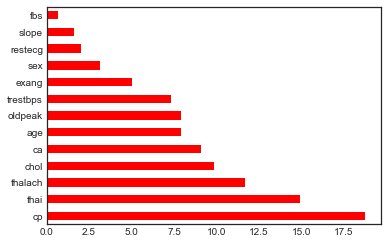

In [700]:
#ref from demonstration 33
pred1=regr.predict(X_test)
for r in range(len(pred1)):
    if pred1[r]>0.5:
        pred1[r]=1
    else:
        pred1[r]=0
importance = pd.Series(regr.feature_importances_ * 100, index = X.columns)
importance = importance.sort_values(axis=0, ascending = False)
importance.plot(kind='barh', color='r', )
len(pred1)
len(y_test)


In [701]:
#ref from demonstration 33
cm1 = pd.DataFrame(confusion_matrix(y_test, pred1).T, index=['No Disease', 'Yes Disease'], columns=['No Disease', 'High Disease'])
cm1.index.name = 'Predicted'
cm1.columns.name = 'True'
print(classification_report(y_test, pred1))
cm1


              precision    recall  f1-score   support

           0       0.82      0.87      0.84        84
           1       0.82      0.75      0.78        65

    accuracy                           0.82       149
   macro avg       0.82      0.81      0.81       149
weighted avg       0.82      0.82      0.82       149



True,No Disease,High Disease
Predicted,,
No Disease,73,16
Yes Disease,11,49


In [702]:
###Logistic Regression with feature selection

In [687]:
#We firt use recusive feature elimination with cross validation to determine what is the ideal number
#of features
#ref:https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
svc = SVC(kernel="linear")
rfecv = RFECV(estimator=svc, step=1, cv=StratifiedKFold(10),
              scoring='accuracy')
rfecv.fit(X, y)
rfecv.support_
X
print("optimal number of features: {0}".format(rfecv.n_features_))


RFECV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
      estimator=SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None,
                    coef0=0.0, decision_function_shape='ovr', degree=3,
                    gamma='scale', kernel='linear', max_iter=-1,
                    probability=False, random_state=None, shrinking=True,
                    tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=None, scoring='accuracy', step=1,
      verbose=0)

array([False,  True,  True, False, False,  True, False, False,  True,
        True,  True,  True,  True])

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thai
0,63,1,1,145,233,1,2,150,0,2.3,3,0,6
1,67,1,4,160,286,0,2,108,1,1.5,2,3,3
2,67,1,4,120,229,0,2,129,1,2.6,2,2,7
3,37,1,3,130,250,0,0,187,0,3.5,3,0,3
4,41,0,2,130,204,0,2,172,0,1.4,1,0,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,57,0,4,140,241,0,0,123,1,0.2,2,0,7
298,45,1,1,110,264,0,0,132,0,1.2,2,0,7
299,68,1,4,144,193,1,0,141,0,3.4,2,2,7
300,57,1,4,130,131,0,0,115,1,1.2,2,1,7


optimal number of features: 8


<Figure size 432x288 with 0 Axes>

Text(0.5, 0, 'Number of features')

Text(0, 0.5, 'Cross validation score')

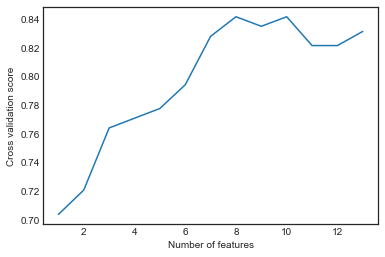

In [688]:
#The graph shows a peak at cv score around feature number of 8
#ref:https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html
plt.figure()
plt.xlabel("Number of features")
plt.ylabel("Cross validation score")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()


In [689]:
#We get the train and test set after feature selection
X_train_select=X_train.drop(columns=['age','trestbps','chol','restecg','thalach'])
X_test_select=X_test.drop(columns=['age','trestbps','chol','restecg','thalach'])
X_train_select.head()

,sex,cp,fbs,exang,oldpeak,slope,ca,thai
117,0,4,0,0,1.4,1,0,3
146,1,4,1,0,1.0,2,3,7
214,1,4,0,0,0.0,1,1,3
237,1,4,0,0,0.8,1,0,7
198,0,2,0,0,1.1,1,0,3


In [690]:
#First we attempt logistic regression without feature selection
log_r = skl_lm.LogisticRegression(solver='newton-cg')
log_r.fit(X_train,y_train)
pred2 = log_r.predict(X_test)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [691]:
print(classification_report(y_test, pred2))

              precision    recall  f1-score   support

           0       0.85      0.85      0.85        84
           1       0.80      0.80      0.80        65

    accuracy                           0.83       149
   macro avg       0.82      0.82      0.82       149
weighted avg       0.83      0.83      0.83       149



In [692]:
#Confusion matrix of the result
#ref from demo 33
cm2 = pd.DataFrame(confusion_matrix(y_test, pred2).T, index=['No disease', 'Yes Disease'], columns=['No Disease', 'Yes Disease'])
cm2.index.name = 'Predicted'
cm2.columns.name = 'True'
cm2

True,No Disease,Yes Disease
Predicted,,
No disease,71,13
Yes Disease,13,52


In [693]:
#Train, test error
print("Accuracy scores:{0},{1}".format(log_r.score(X_train,y_train),log_r.score(X_test,y_test)))

Accuracy scores:0.8513513513513513,0.825503355704698


In [694]:
#With feature selection
log_r_select = skl_lm.LogisticRegression(solver='newton-cg')
log_r_select.fit(X_train_select,y_train)
pred3 = log_r_select.predict(X_test_select)
print(classification_report(y_test, pred3))

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

              precision    recall  f1-score   support

           0       0.85      0.87      0.86        84
           1       0.83      0.80      0.81        65

    accuracy                           0.84       149
   macro avg       0.84      0.83      0.84       149
weighted avg       0.84      0.84      0.84       149



In [695]:
#Train,t test error
print("Accuracy scores:{0},{1}".format(log_r_select.score(X_train_select,y_train),\
                                                                                 log_r_select.score(X_test_select,y_test)))

Accuracy scores:0.8513513513513513,0.8389261744966443


In [696]:
#Confusion matrix
cm3 = pd.DataFrame(confusion_matrix(y_test, pred3).T, index=['No disease', 'Yes Disease'], columns=['No Disease', 'Yes Disease'])
cm3.index.name = 'Predicted'
cm3.columns.name = 'True'
cm3

True,No Disease,Yes Disease
Predicted,,
No disease,73,13
Yes Disease,11,52


In [438]:
#Comment: We can see there is a slight improvement at the accuracy after performing feature selection.

In [ ]:
#Comment: overall by comparing f1 score and accuracy, we have logistic regression being the top performer/
#by a slim margin, and single decision tree being the worst performer.  
#Please refer to the written report for more details